In [244]:
#Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/redux'
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
from vgg16 import Vgg16

import time

from keras.preprocessing import image

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

In [4]:
# iniialize the model
vgg = Vgg16()

In [302]:
batch_size = 32
epochs = 1
path = DATA_HOME_DIR + '/'
valid_path = path + 'louie/'

In [16]:
train_batches = vgg.get_batches(path + 'train/', batch_size=batch_size)
valid_batches = vgg.get_batches(path + 'valid/', batch_size=batch_size)
vgg.finetune(train_batches)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [18]:
for e in range(epochs):
    vgg.fit(train_batches, valid_batches)

Epoch 1/1
200/200 [==============================] - 7s - loss: 1.2509 - acc: 0.6850 - val_loss: 0.0798 - val_acc: 0.9800


In [246]:
vgg.model.save_weights(path + 'results/model' + str(time.time()))

In [249]:
vgg.model.load_weights(DATA_HOME_DIR + '/results/ft1.h5')

In [316]:
test_batches, preds = vgg.test(valid_path, batch_size=batch_size)

Found 1 images belonging to 2 classes.


In [317]:
test_batches.class_indices

{'cats': 0, 'dogs': 1}

In [318]:
print preds[:5]
print test_batches.filenames[:5]

[[  6.0389e-04   9.9940e-01]]
['dogs/dog.1.jpg']


In [319]:
def onehot(batches):
    num_classes = len(batches.class_indices)
    return np.equal(batches.classes, np.matrix(np.arange(num_classes)).T).T.astype(int)

In [320]:
def logloss(batches, preds):
    preds = np.clip(preds, 0.0001, 0.9999)
    v1 = np.multiply(test_batches.classes, np.log(preds[:, 1]))
    v2 = np.multiply(1-test_batches.classes, np.log(1-preds[:, 1]))
    return np.sum(np.add(v1, v2)) / -test_batches.N

In [321]:
logloss(test_batches, preds)

0.00060409668367356062

In [331]:
labels = np.round(1-preds[:,0])
text_labels = ["dog" if dog else "cat" for dog in labels]
correct_labels = labels == test_batches.classes
correct_cats = correct_labels & (test_batches.classes==0)
correct_dogs = correct_labels & (test_batches.classes==1)
wrong_cats = ~correct_labels & (test_batches.classes==0)
wrong_dogs = ~correct_labels & (test_batches.classes==1)

In [332]:
def plot_images(batches, labels, preds, idxs, num, path):
    if len(idxs) == 0:
        return
    idxs = np.random.choice(idxs, num)
    filenames = [path + batches.filenames[i] for i in idxs]
    labels = [str(labels[i]) + " " + str(preds[i]) for i in idxs]
    plots([image.load_img(f) for f in filenames], titles=labels)

# Wrong dogs

In [334]:
plot_images(test_batches, text_labels, 1-preds[:, 0], np.where(wrong_dogs)[0], 4, valid_path)

# Wrong cats

In [335]:
plot_images(test_batches, text_labels, 1-preds[:, 0], np.where(wrong_cats)[0], 1, valid_path)

# Correct dogs

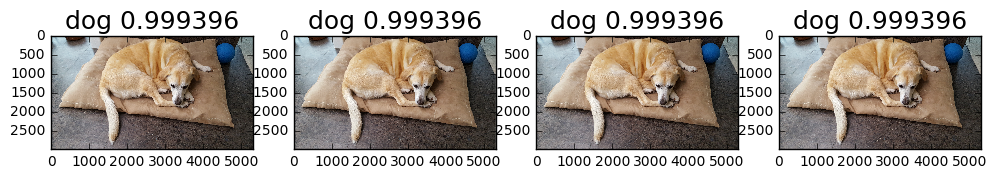

In [336]:
plot_images(test_batches, text_labels, 1-preds[:, 0], np.where(correct_dogs)[0], 4, valid_path)

# Correct cats

In [337]:
plot_images(test_batches, text_labels, 1-preds[:, 0], np.where(correct_cats)[0], 4, valid_path)